In [1]:
!pip install spacy
!python -m spacy download el_core_news_md
!pip install unidecode
!pip install optuna
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 MB 33.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_md')


IMPORTS

In [2]:
############################################ IMPORTS ################################################
import numpy as np # linear algebra
import pandas as pd # READ CSV
import spacy
import unicodedata as ud

# utilities
import re
# plotting

from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import os
from spacy.lang.el import stop_words
from sklearn.feature_extraction.text import CountVectorizer
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import optuna
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc

FUNCTIONS

In [3]:
############################################ FUNCTION ################################################
def remove_hashtags(text):
    result = re.sub(r'#\S+', '', text)
    return ' '.join(result.split())

def remove_accents(text):
    tras = {ord('\N{COMBINING ACUTE ACCENT}'):None}
    ud.normalize('NFD', text).upper().translate(tras)
    result = ud.normalize('NFD', text).translate(tras)
    return ' '.join(result.split())

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return ' '.join(result.split())

def remove_more_characters(text):
    result = re.sub(r'(.)\1+', r'\1', text)
    return ' '.join(result.split())

def remove_at_words(text):
    result = re.sub(r'@\S+', '', text)
    return ' '.join(result.split())

def cleaning_punctuations(text):
    translator = str.maketrans(punctuations_list, ' ' * len(punctuations_list))
    result = text.translate(translator)
    return' '.join(result.split())

def remove_url(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ', text)

def create_tokenizer(text):
    return word_tokenize(text)


def remove_stopwords(text):
    words = text.split()
    not_stopwords = [word for word in words if word.lower() not in stop_words_without_accents]
    result = ' '.join(not_stopwords)
    return ' '.join(result.split())

def remove_stopwords_without_accents(text):
    words = text.split()
    not_stopwords = [word for word in words if word.lower() not in stop_words]
    result = ' '.join(not_stopwords)
    return ' '.join(result.split())

def remove_english_stopwords(text):
    words = text.split()
    not_stopwords = [word for word in words if word.lower() not in stop_words]
    result = ' '.join(not_stopwords)
    return ' '.join(result.split())

def remove_one(text):
    words = text.split()
    filtered_words = [word for word in words if len(word) != 1]
    return ' '.join(filtered_words)

In [4]:
nltk.download('punkt')
english_punctuations = string.punctuation + '«»'
punctuations_list = english_punctuations
nlp = spacy.load("el_core_news_md")
stop_words = nlp.Defaults.stop_words
nltk.download('stopwords')
english_stop_words = set(stopwords.words('english'))
stop_words_without_accents = create_tokenizer(remove_accents(' '.join(stop_words)))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**spaCy** functions

In [5]:
############################################ FUNCTION using SPACY ################################################

def remove_url_spacy(text):
  document = nlp(text)
  not_url = [token.text for token in document if not token.like_url]
  text = " ".join(not_url)
  return text

def remove_at_words_spacy(text):
  document = nlp(text)
  not_at = [token.text for token in document if (not token.text.startswith('@'))]
  text = " ".join(not_at)
  return text

def remove_puncuation(text):
  document = nlp(text)
  not_punctuation = [token.text for token in document if not token.is_punct and not token.is_space]
  text = " ".join(not_punctuation)
  return text

def remove_stopwords_spacy(text):
  document = nlp(text)
  not_stopwords = [token.text for token in document if token.text.lower() not in stop_words]
  text = " ".join(not_stopwords)
  return text

def create_tokenizer_spacy(text):
  document = nlp(text)
  tokens = [token.text for token in document]
  return tokens

def remove_lemma(text):
  doc = nlp(text)
  the_lemma = " ".join([token.lemma_ for token in doc])
  text = " ".join(the_lemma)
  return text

**PRE**-**PROCESS**

In [6]:
def create_model(file_path, file):
  dataset = pd.read_csv(file_path)

  dataset. shape
  dataset.dtypes
  np.sum(dataset.isnull().any(axis=1))
  dataset['New_ID'].unique()
  dataset['New_ID'].nunique()

  dataset['Text'] = dataset['Text'].str.lower()
  dataset['Text'] = dataset['Text'].apply(remove_hashtags)
  dataset['Text'] = dataset['Text'].apply(remove_url)
  dataset['Text'] = dataset['Text'].apply(remove_numbers)
  dataset['Text'] = dataset['Text'].apply(remove_stopwords)
  dataset['Text'] = dataset['Text'].apply(remove_english_stopwords)
  dataset['Text'] = dataset['Text'].apply(remove_accents)
  dataset['Text'] = dataset['Text'].apply(remove_stopwords_without_accents)
  dataset['Text'] = dataset['Text'].apply(remove_at_words)
  dataset['Text'] = dataset['Text'].apply(cleaning_punctuations)
  dataset['Text'] = dataset['Text'].apply(create_tokenizer)

  if 'train' in file:
    dataset['Sentiment'] = dataset['Sentiment'].replace({'POSITIVE': 2, 'NEGATIVE': 0, 'NEUTRAL': 1})
    path = 'train_set_result.csv'
  elif 'valid' in file:
    dataset['Sentiment'] = dataset['Sentiment'].replace({'POSITIVE': 2, 'NEGATIVE': 0, 'NEUTRAL': 1})
    path = 'valid_set_result.csv'
  else:
    path = 'test_set_result.csv'
    
  return dataset

In [7]:
train_dataset = create_model('/kaggle/input/ys19-2023-assignment-1/train_set.csv', 'train')
valid_dataset = create_model('/kaggle/input/ys19-2023-assignment-1/valid_set.csv', 'valid')

X_train = train_dataset['Text'].astype(str).tolist()
y_train = train_dataset['Sentiment']

X_validation = valid_dataset['Text'].astype(str).tolist()
y_validation = valid_dataset['Sentiment']

**Vectorizer**

In [8]:
count_vec = CountVectorizer(max_features=5000)
X_train_count = count_vec.fit_transform(X_train)
X_validation_count = count_vec.transform(X_validation)

**LOGISTIC REGRESSION**

In [9]:
log_model = LogisticRegression(max_iter = 2000)
log_model.fit(X_train_count, y_train)
y_validation_pred = log_model.predict(X_validation_count)

print("Accuracy valid: ", accuracy_score(y_validation, y_validation_pred))
print("Validation class:\n", classification_report(y_validation, y_validation_pred))

Accuracy valid:  0.3862767584097859
Validation class:
               precision    recall  f1-score   support

           0       0.38      0.38      0.38      1744
           1       0.38      0.42      0.40      1744
           2       0.40      0.36      0.38      1744

    accuracy                           0.39      5232
   macro avg       0.39      0.39      0.39      5232
weighted avg       0.39      0.39      0.39      5232



**Predict the test_set.csv and create sample_submission.csv**

In [10]:
dataset_test = create_model('/kaggle/input/ys19-2023-assignment-1/test_set.csv', 'test')

X_test = dataset_test['Text'].astype(str).tolist()
X_test_count = count_vec.transform(X_test)

log_model = LogisticRegression(max_iter = 2000)
log_model.fit(X_train_count, y_train)
y_validation_pred = log_model.predict(X_validation_count)
y_test = log_model.predict(X_test_count)

result_df = pd.DataFrame({'Id': dataset_test['New_ID'], 'Predicted': y_test})
result_df['Predicted'] = result_df['Predicted'].replace({2: 'POSITIVE', 0: 'NEGATIVE', 1: 'NEUTRAL'})
path = 'submission.csv'
result_df.to_csv(path, index=False, encoding='utf-8')

**Test**

**HYPERPARAMETER** **TUNING**

In [11]:
def objective(trial):
    params = {
        'tol': trial.suggest_uniform('tol', 1e-6, 1e-3),
        'C': trial.suggest_loguniform("C", 1e-2, 1),
        "n_jobs" : -1
    }

    count_vec = CountVectorizer(max_features=5000)
    X_train_count = count_vec.fit_transform(X_train)
    X_validation_count = count_vec.transform(X_validation)


    log_model = LogisticRegression(**params,max_iter = 2000)
    log_model.fit(X_train_count, y_train)
    y_validation_pred = log_model.predict(X_validation_count)

    accuracy = accuracy_score(y_validation, y_validation_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_model = LogisticRegression(**best_params, max_iter=2000, random_state=0)
best_model.fit(X_train_count, y_train)

X_validation_count = count_vec.transform(X_validation)
y_validation_pred = best_model.predict(X_validation_count)

print("Best params:", best_params)
print("Accuracy valid:", accuracy_score(y_validation, y_validation_pred))
print("Validation class:\n", classification_report(y_validation, y_validation_pred))

[I 2023-11-23 20:09:43,008] A new study created in memory with name: no-name-4e7926fb-f3b3-4c27-8501-0279e52a30fa
/tmp/ipykernel_20/790936554.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol': trial.suggest_uniform('tol', 1e-6, 1e-3),
/tmp/ipykernel_20/790936554.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform("C", 1e-2, 1),
[I 2023-11-23 20:09:44,991] Trial 0 finished with value: 0.3941131498470948 and parameters: {'tol': 0.0007505221415041443, 'C': 0.012605976234656984}. Best is trial 0 with value: 0.3941131498470948.
/tmp/ipykernel_20/790936554.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v

Best params: {'tol': 0.0008499687630334073, 'C': 0.010002416760993617}
Accuracy valid: 0.3958333333333333
Validation class:
               precision    recall  f1-score   support

           0       0.39      0.44      0.41      1744
           1       0.39      0.41      0.40      1744
           2       0.42      0.35      0.38      1744

    accuracy                           0.40      5232
   macro avg       0.40      0.40      0.40      5232
weighted avg       0.40      0.40      0.40      5232



**LEARNING CURVE**

F1 Score Train: 0.972097284690988
F1 Score Validation: 0.3061033552076609
F1 Score Train: 0.9016647971313482
F1 Score Validation: 0.3732630342485294
F1 Score Train: 0.8127628323758084
F1 Score Validation: 0.3743743492938138
F1 Score Train: 0.7411425056159044
F1 Score Validation: 0.37039623566721724
F1 Score Train: 0.6917079578652569
F1 Score Validation: 0.38266414528807097
F1 Score Train: 0.6466237670906295
F1 Score Validation: 0.37078190496457486
F1 Score Train: 0.6189211495823265
F1 Score Validation: 0.3699288698321651
F1 Score Train: 0.5992605805664318
F1 Score Validation: 0.37772550568846147
F1 Score Train: 0.5796907003916718
F1 Score Validation: 0.3822506011231476
F1 Score Train: 0.5676706103895286
F1 Score Validation: 0.38077725158000436


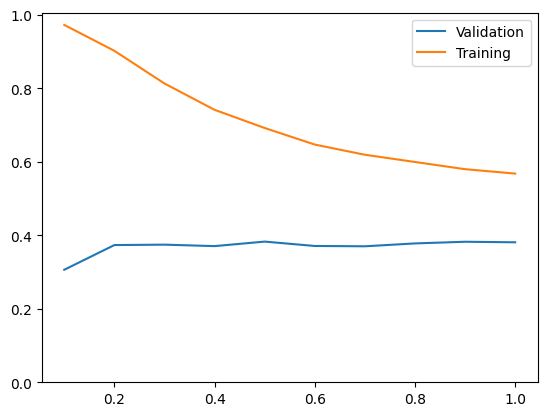

In [12]:
list_f1=[]
list_f1_train=[]
list_sample_size=[]
for times in range(10):

  X_train_subset, _, y_train_subset, _ = train_test_split(X_train_count,y_train, test_size=1-(times*0.1 + 0.001))

  classifier = LogisticRegression(max_iter=2000)
  classifier.fit(X_train_subset, np.ravel(y_train_subset))

  results_train = classifier.predict(X_train_subset)

  # validation
  #
  results = classifier.predict(X_validation_count)

  # score
  #
  f1_train = f1_score(y_train_subset, results_train, average='weighted')
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(y_validation, results, average='weighted')
  print("F1 Score Validation: " + str(f1))

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])
plt.show()

**ROC CURVE**

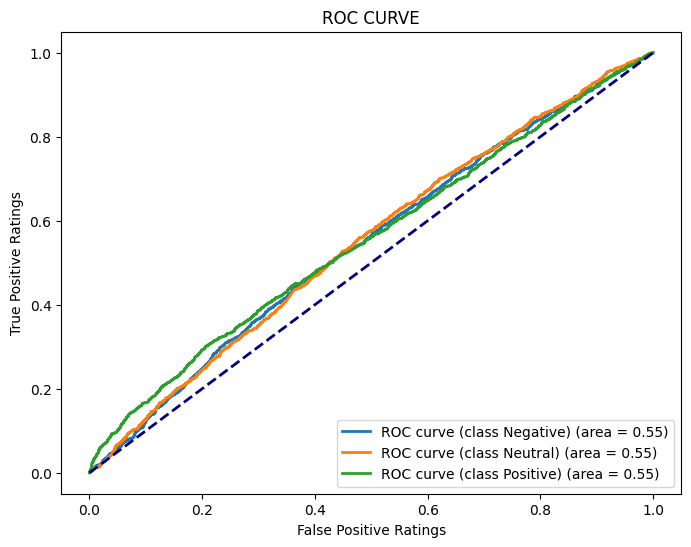

In [13]:
def take_sentiment(i):
  if i == 2:
    return 'Positive'
  elif i == 0:
    return 'Negative'
  else:
    return'Neutral'

y_validation_binarized = label_binarize(y_validation, classes=[0, 1, 2])

# Εκπαίδευση του μοντέλου και πρόβλεψη πιθανοτήτων
log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train_count, y_train)
y_validation_probs = log_model.predict_proba(X_validation_count)

# ROC AND AUC
n_classes = len(np.unique(y_train))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_validation_binarized[:, i], y_validation_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Σχεδίαση ROC
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {}) (area = {:0.2f})'.format(take_sentiment(i), roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Ratings')
plt.ylabel('True Positive Ratings')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()


**CONFUSION MATRIX**

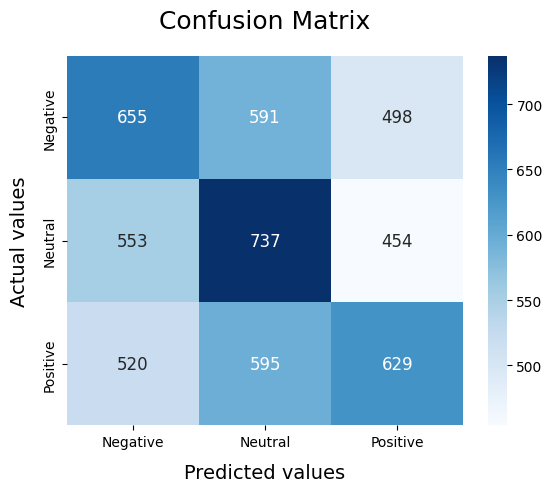

In [14]:
import seaborn as sns
def confusion_matrix_model(model):
    y_pred = model.predict(X_validation_count)

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_validation, y_pred)

    # Negative, Neutral and Positive Categories
    categories = ['Negative', 'Neutral', 'Positive']
    group_names = ['True Neg', 'False Neutral', 'False Pos',
                   'False Neg', 'True Neutral', 'True Pos']  # ορίζουμε τις ονομασίες ομάδων
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 3)

    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='', annot_kws={"size": 12},
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()

log_model = LogisticRegression(max_iter = 2000)
log_model.fit(X_train_count, y_train)
confusion_matrix_model(log_model)
y_validation_pred = log_model.predict(X_validation_count)